
Welcome to the **DS Fundamentals - March Madness** workshop!

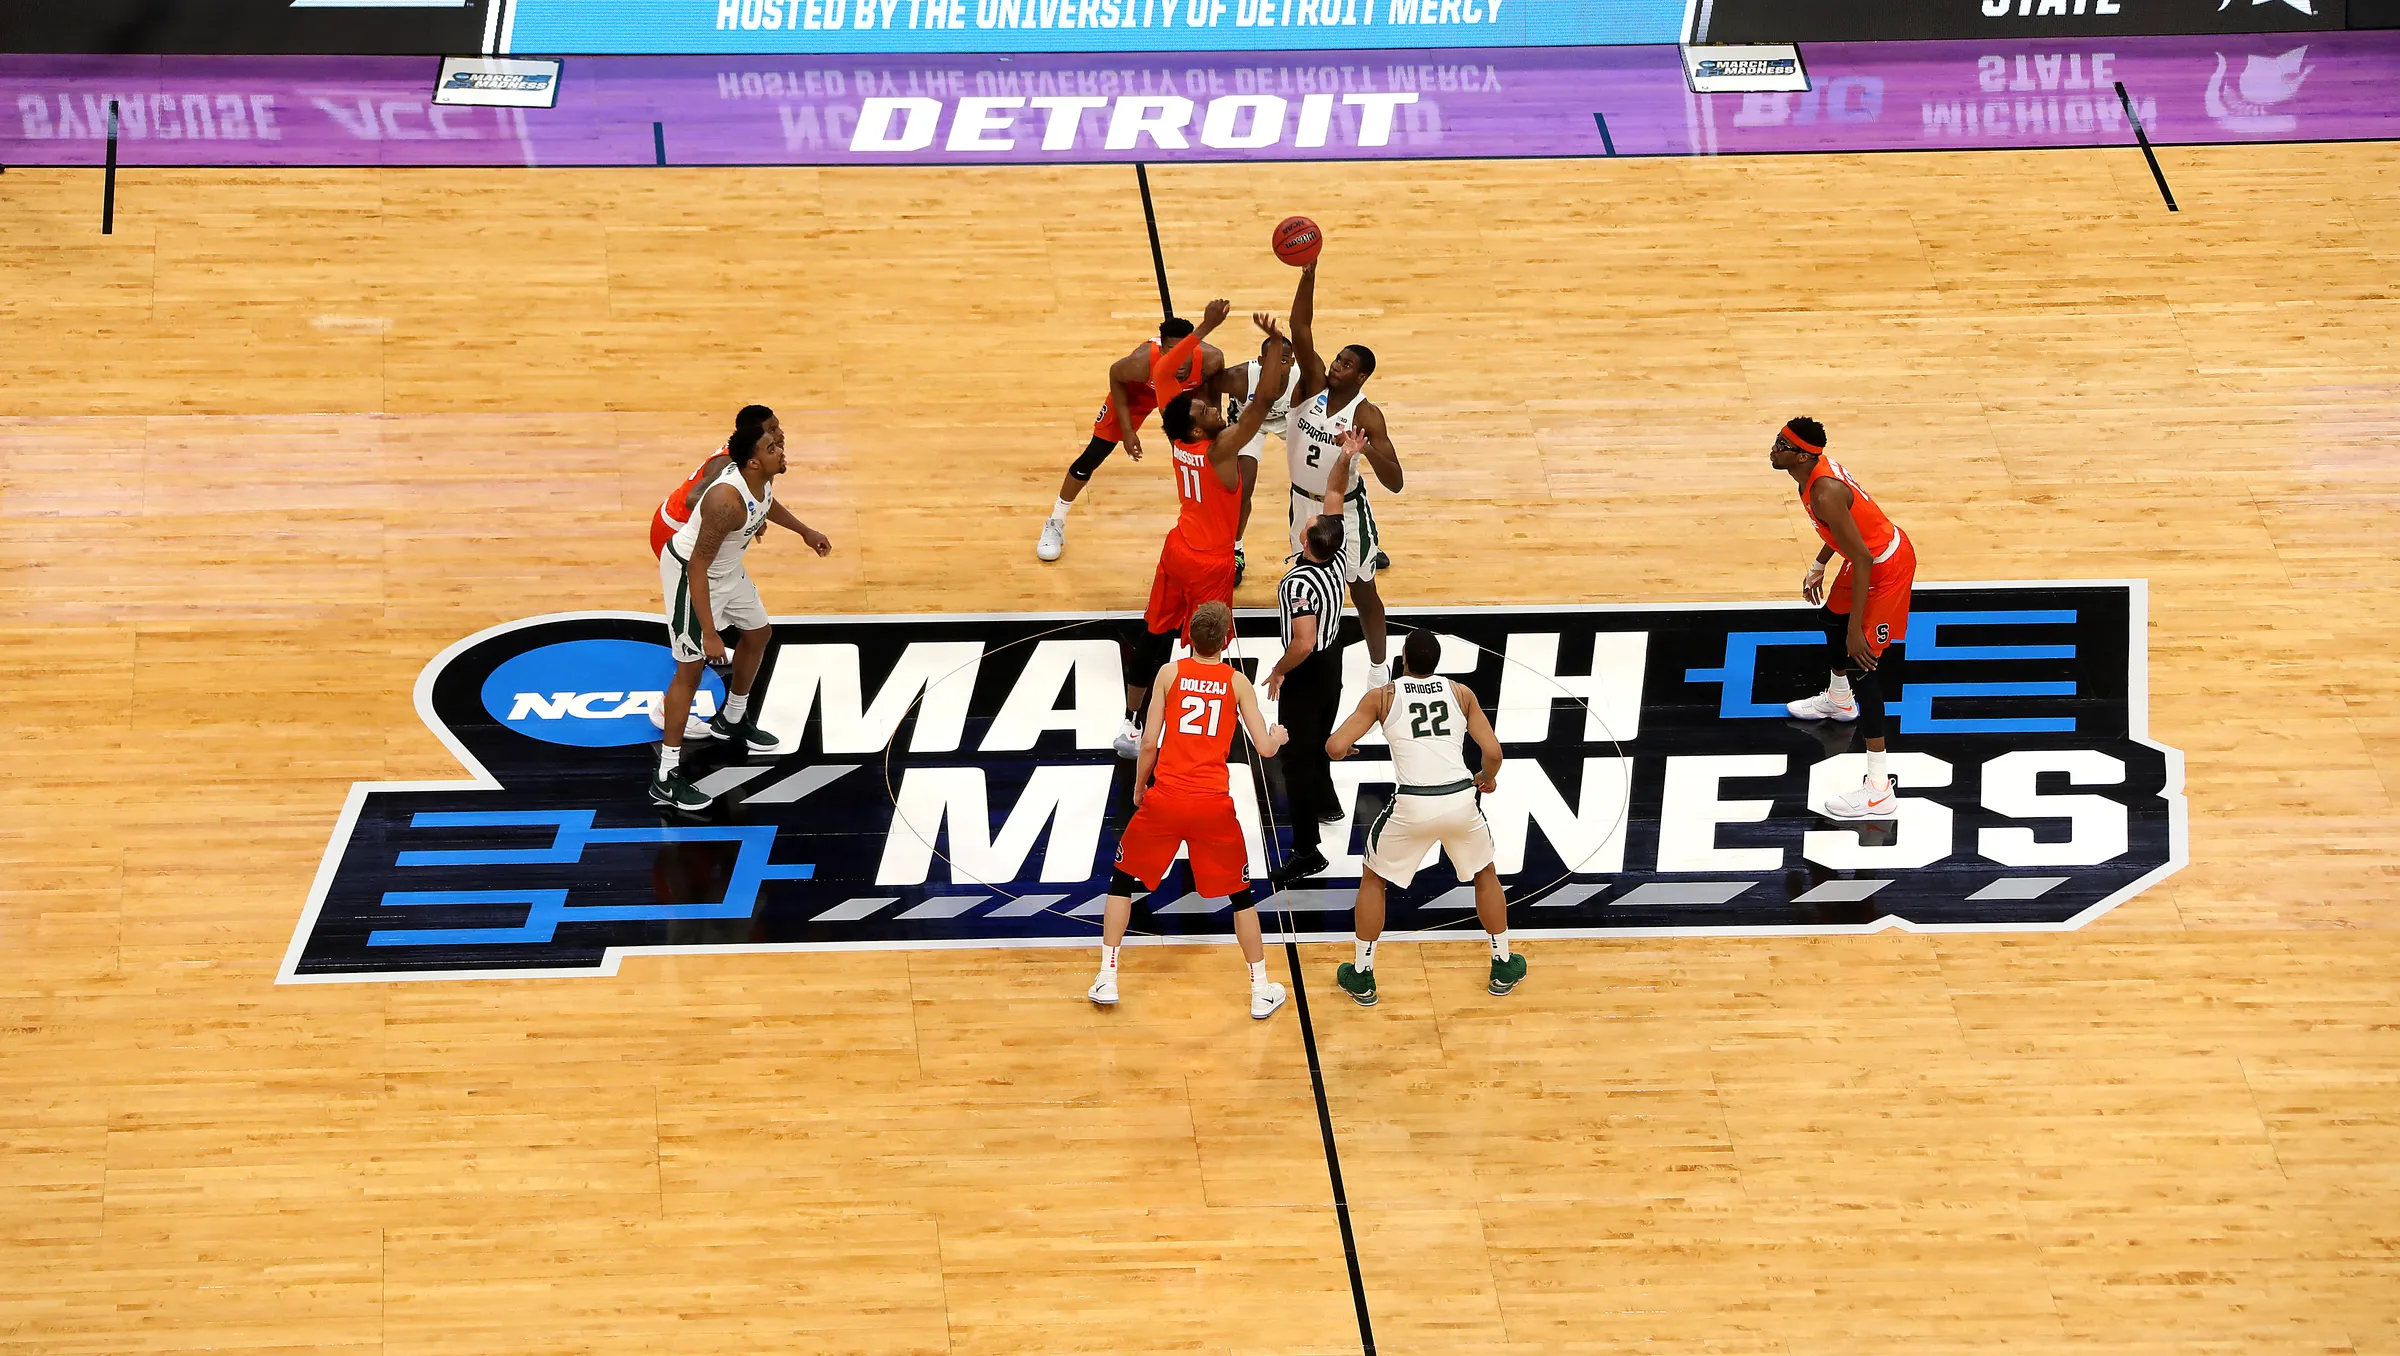

The objective for this workshop is to create predictions for the winners of the 2023 March Madness tournament. Since this is historical data, we already know the winning bracket from this event, but we will attempt to make reasonable predictions without biasing it with hindsight.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
import random

In [ ]:
!gdown "https://drive.google.com/uc?id=15IJoEfDACrDVeO46V9rWp0-B18B5sRxq"
!unzip /content/march-machine-learning-mania-2023.zip

Downloading...
From: https://drive.google.com/uc?id=15IJoEfDACrDVeO46V9rWp0-B18B5sRxq
To: /content/march-machine-learning-mania-2023.zip
100% 29.9M/29.9M [00:00<00:00, 39.1MB/s]
Archive:  /content/march-machine-learning-mania-2023.zip
  inflating: Cities.csv              
  inflating: Conferences.csv         
  inflating: MConferenceTourneyGames.csv  
  inflating: MGameCities.csv         
  inflating: MMasseyOrdinals_thru_Season2023_Day128.csv  
  inflating: MNCAATourneyCompactResults.csv  
  inflating: MNCAATourneyDetailedResults.csv  
  inflating: MNCAATourneySeedRoundSlots.csv  
  inflating: MNCAATourneySeeds.csv   
  inflating: MNCAATourneySlots.csv   
  inflating: MRegularSeasonCompactResults.csv  
  inflating: MRegularSeasonDetailedResults.csv  
  inflating: MSeasons.csv            
  inflating: MSecondaryTourneyCompactResults.csv  
  inflating: MSecondaryTourneyTeams.csv  
  inflating: MTeamCoaches.csv        
  inflating: MTeamConferences.csv    
  inflating: MTeamSpellings.csv

# Data Selection

We just downloaded a lot of data, but we don't want to to use all of it, so let's carefully select what we want to use.

For descriptions of each of these csv files check here: https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data. This will be especially useful if you want to choose your own data.


For now, the first plan is to use tournament seed data

In [ ]:
reg_season = pd.read_csv("MRegularSeasonCompactResults.csv")
tourney_seeds = pd.read_csv("MNCAATourneySeeds.csv")

tourney_stats = pd.read_csv("MNCAATourneyCompactResults.csv")

team_names = pd.read_csv("MTeams.csv")

# Processing

Once we've selected what data we want, and we have some idea of what methods we're going to use for it, we have to format the data into a convenient form.

In [ ]:
print(tourney_seeds)

      Season Seed  TeamID
0       1985  W01    1207
1       1985  W02    1210
2       1985  W03    1228
3       1985  W04    1260
4       1985  W05    1374
...      ...  ...     ...
2485    2023  Z12    1433
2486    2023  Z13    1233
2487    2023  Z14    1213
2488    2023  Z15    1421
2489    2023  Z16    1224

[2490 rows x 3 columns]


In [ ]:
print(reg_season)

        Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0         1985      20     1228      81     1328      64    N      0
1         1985      25     1106      77     1354      70    H      0
2         1985      25     1112      63     1223      56    H      0
3         1985      25     1165      70     1432      54    H      0
4         1985      25     1192      86     1447      74    H      0
...        ...     ...      ...     ...      ...     ...  ...    ...
181677    2023     132     1104      82     1401      63    N      0
181678    2023     132     1272      75     1222      65    A      0
181679    2023     132     1343      74     1463      65    H      0
181680    2023     132     1345      67     1336      65    N      0
181681    2023     132     1433      68     1173      56    N      0

[181682 rows x 8 columns]


In [ ]:
names = {}

for i, row in team_names.iterrows():
    id = int(row["TeamID"])
    team_name = row["TeamName"]
    names[team_name] = id
    names[id] = team_name

In [ ]:
# Dictionary of team ID, to year, to seed
team_seeds = {}  # Dict[int: Dict[int: int]]

for i, row in tourney_seeds.iterrows():

    team_id = int(row["TeamID"])
    seed = int(row["Seed"][1:3])
    year = int(row["Season"])

    if team_id in team_seeds:
        team_seeds[team_id][year] = seed
    else:
        team_seeds[team_id] = {}
        team_seeds[team_id][year] = seed

print(team_seeds)

def get_seed_data(team_id):
    default_seed = 17 # higher than max seed

    # This fills in missing years with default_seed
    all_years_seeds = [team_seeds.get(team_id, {}).get(year, default_seed) for year in range(1985, 2024)]

    return np.array(all_years_seeds)

{1207: {1985: 1, 1986: 4, 1987: 1, 1988: 8, 1989: 1, 1990: 3, 1991: 8, 1992: 6, 1994: 9, 1995: 6, 1996: 2, 1997: 10, 2001: 10, 2006: 7, 2007: 2, 2008: 2, 2010: 3, 2011: 6, 2012: 3, 2013: 2, 2015: 4, 2021: 12}, 1210: {1985: 2, 1986: 2, 1987: 7, 1988: 5, 1989: 6, 1990: 4, 1991: 8, 1992: 7, 1993: 4, 1996: 3, 2001: 8, 2004: 3, 2005: 5, 2007: 10, 2010: 10, 2021: 9}, 1228: {1985: 3, 1986: 4, 1987: 3, 1988: 3, 1989: 1, 1990: 5, 1993: 6, 1994: 8, 1995: 11, 1997: 6, 1998: 5, 2000: 4, 2001: 1, 2002: 4, 2003: 4, 2004: 5, 2005: 1, 2006: 4, 2007: 12, 2009: 5, 2011: 9, 2013: 7, 2021: 1, 2022: 4, 2023: 9}, 1260: {1985: 4, 2018: 11, 2021: 8, 2022: 10}, 1374: {1985: 5, 1988: 7, 1993: 10, 2015: 6, 2017: 6}, 1208: {1985: 6, 1987: 8, 1990: 7, 1991: 11, 1996: 8, 1997: 3, 2001: 8, 2002: 3, 2008: 14, 2011: 10, 2015: 10}, 1393: {1985: 7, 1986: 2, 1987: 2, 1988: 3, 1989: 2, 1990: 2, 1991: 2, 1992: 6, 1994: 4, 1995: 7, 1996: 4, 1998: 5, 1999: 8, 2000: 4, 2001: 5, 2003: 3, 2004: 5, 2005: 4, 2006: 5, 2009: 3, 201

In [ ]:
# Dictionary of team ID, to opponent team ID, to record
team_records = {}  # Dict[int: Dict[int: int]]

for i, row in reg_season.iterrows():
    # Each row in this dataframe is one match

    winning_team = int(row["WTeamID"])
    losing_team = int(row["LTeamID"])

    winning_score = int(row["WScore"])
    losing_score = int(row["LScore"])

    # TODO: Place into info_vec any variables that would be important, including your own custom ones
    # How would we keep track of the total score difference and total record?
    info_vec = np.array([     winning_score - losing_score, 1     ])


    if winning_team not in team_records:
        team_records[winning_team] = {}
    if losing_team not in team_records[winning_team]:
        team_records[winning_team][losing_team] = np.zeros_like(info_vec)
    if losing_team not in team_records:
        team_records[losing_team] = {}
    if winning_team not in team_records[losing_team]:
        team_records[losing_team][winning_team] = np.zeros_like(info_vec)


    team_records[winning_team][losing_team] += info_vec
    # We want this to be symmetric for winning team vs losing team
    team_records[losing_team][winning_team] -= info_vec


# TODO: Also try only considering matches from a certain year onwards, in order to remove outdated data

def get_season_data(team1, team2):
    return team_records.get(team1, {}).get(team2, np.zeros_like(info_vec))

In [ ]:
def get_match_data(team1, team2):
  t1_seed = get_seed_data(team1)
  t2_seed = get_seed_data(team2)
  season = get_season_data(team1, team2)
  return np.concatenate((t1_seed, t2_seed, season), axis=None)

# Training Procedure

The training procedure involves loading the data and determining the results.

This documentation will be helpful! https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


In [ ]:
# Generate training data
X_train = []
y_train = []

for i, row in reg_season.iterrows():
    winning_team = int(row["WTeamID"])
    losing_team = int(row["LTeamID"])

    # Randomize the winner order
    if random.random() < 0.5:
        X_train.append(get_match_data(losing_team, winning_team))
        y_train.append(0)  # 0 for losing, 1 for winning
    else:
        X_train.append(get_match_data(winning_team, losing_team))
        y_train.append(1)

In [ ]:
model = # TODO: Create the sklearn logistic regression model
out = # TODO: Fit the data for our logistic model
# Ignore error

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Prediction

In [ ]:
# Returns 0 or 1 indicating the truth value of team 1 winning
def win_match(model, team1, team2):
    X_predict = np.array([get_match_data(team1, team2)])
    out = # TODO: Predict the data for our logistic model

    return out[0]


As you test your results, you may find that there is new types of data you want to use, and new methods of prediction you want to try (which may also require different processing). Feel free to iterate as far back as data selection.

# Testing

The bracket solving function is provided. It just iteratively gets the data for each team, runs your prediction model, and advances the winner.

In [ ]:
def predict_bracket(bracket, model):
  winners = []
  while len(bracket) >= 2:
      team1 = bracket.pop(0)
      team2 = bracket.pop(0)
      if win_match(model, team1, team2):
          winners.append(team1)
      else:
          winners.append(team2)

  winners += bracket  # BYE for odd number bracket
  winner_names = [names[winner] for winner in winners]
  if len(winners) >= 2:
      print("Round winners:", winner_names)
      predict_bracket(winners, model)
  else:
      print("Final winner:", winner_names[0])

In [ ]:
bracket_south = [1104, 1401, 1268, 1452, 1360, 1149, 1438, 1202, 1166, 1301, 1124, 1364, 1281, 1429, 1112, 1343]
bracket_midwest = [1222, 1297, 1234, 1120, 1274, 1179, 1231, 1245, 1235, 1338, 1462, 1244, 1401, 1336, 1400, 1159]
bracket_east = [1345, 1193, 1273, 1194, 1181, 1331, 1397, 1418, 1246, 1344, 1243, 1286, 1277, 1425, 1266, 1436]
bracket_west = [1242, 1224, 1116, 1228, 1338, 1433, 1163, 1233, 1395, 1113, 1211, 1213, 1321, 1129, 1417, 1421]


predict_bracket(bracket_south, model)

Round winners: ['Alabama', 'Maryland', 'San Diego', 'Virginia', 'NC State', 'Baylor', 'Missouri', 'Arizona']
Round winners: ['Maryland', 'Virginia', 'NC State', 'Arizona']
Round winners: ['Maryland', 'Arizona']
Final winner: Arizona


How did your model do? Compare this to the actual bracket here! https://www.ncaa.com/march-madness-live/bracket


# Sandbox

Try something else! Example: build a simple neural network with Tensorflow.